In [3]:
# from google.colab import drive
# drive.mount("/content/gdrive/")

Mounted at /content/gdrive/




# Libraries

In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import random
import zipfile
import numpy as np
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
from time import time
from time import sleep
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import sklearn
import sklearn.metrics as metrics
## Neural nets
#.....................................
import tensorflow as tf
from keras.models import Sequential
from tensorflow import keras
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Conv2D, Flatten, MaxPooling2D, GaussianNoise
from keras.callbacks import History
from tensorflow.keras import layers
# image augmentation
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot


# Defining the subdir

In [ ]:
subdir = ['Male','Female']

In [ ]:
# for i in subdir:
#   print("/content/Validation.zip/"+i+"/*.png")

/content/Validation.zip/Male/*.png
/content/Validation.zip/Female/*.png


# Creating the train dataset

In [ ]:
img_lbl=[]
for gender in subdir:
  for im_path in glob.glob("Validation.zip/"+gender+"/*.png"):
    if gender =='Male':
      img_lbl.append([cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB),'M'])
    else:
      img_lbl.append([cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB),'F'])


In [ ]:
trn_img=[]
trn_lbl=[]
for i in range(len(img_lbl)):
  trn_img.append(img_lbl[i][0])
  trn_lbl.append(img_lbl[i][1])

0


# Creating test dataset

In [ ]:
test_subdir=["man","woman"]

In [ ]:

height=100
width=100
dim=(width,height)
tst_img_lbl=[]
for gender in test_subdir:
  for im_path in glob.glob("archive (1)/faces/"+gender+"/*.jpg"): #change the archive (1) with the correct file name after extracting the zip file.
    if gender=='man':
      tst_img_lbl.append([cv2.resize(cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB),dim),'M'])
    else:
      tst_img_lbl.append([cv2.resize(cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB),dim),'F'])

In [ ]:
test_img=[]
test_lbl=[]
for i in range(len(tst_img_lbl)):
  test_img.append(tst_img_lbl[i][0])
  test_lbl.append(tst_img_lbl[i][1])

# Creating the validation dataset

In [ ]:
val_img_lbl=[]
for gender in subdir:
  for im_path in glob.glob("archive/Test/Test/"+gender+"/*.png"):
    if gender =='Male':
      val_img_lbl.append([cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB),'M'])
    else:
      val_img_lbl.append([cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB),'F'])


In [ ]:
val_img=[]
val_lbl=[]
for i in range(len(val_img_lbl)):
  val_img.append(val_img_lbl[i][0])
  val_lbl.append(val_img_lbl[i][1])

### Converting the images to compressed npz form of npy file type and saving it for easy access for future use and manipulation.

In [ ]:
np.savez("train_dataset.npz", img=trn_img, lbl=trn_lbl)

In [ ]:
np.savez("validation_dataset.npz", img=val_img, lbl=val_lbl)

In [ ]:
np.savez("test_dataset.npz", img=test_img, lbl=test_lbl)

# Loading the npz file and displaying first 5 images

In [4]:
with np.load("train_dataset.npz") as data:
        img = data["img"]
        lbl = data["lbl"]

In [5]:
with np.load("validation_dataset.npz") as data:
        val_img = data["img"]
        val_lbl = data["lbl"]

In [6]:
with np.load("test_dataset.npz") as data:
        test_img = data["img"]
        test_lbl = data["lbl"]

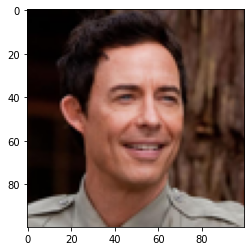

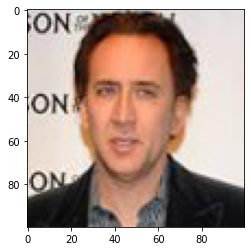

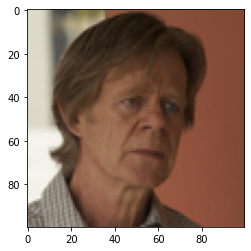

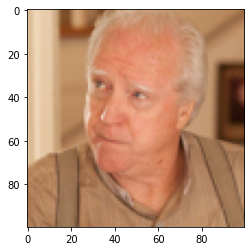

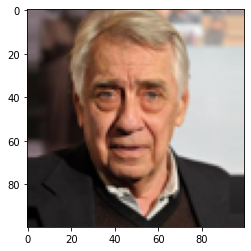

In [ ]:
# #print(img.shape)
# for im in range(5):
#     image = img[im]
#     image = np.array(image, dtype='float')
#     plt.imshow(((image).astype('float32'))/255)
#     plt.show()

## Splitting the Train data to train and test set and creating the variable for the validation data

In [7]:
X_train, y_train = (img, lbl)

In [8]:
X_test,y_test=(test_img,test_lbl)

In [9]:
X_val,y_val=(val_img, val_lbl)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(11135, 100, 100, 3)
(27167, 100, 100, 3)
(1279, 100, 100, 3)
(11135,)
(27167,)
(1279,)


## Implementing the baseline CNN algorithm

### Pre-processing

In [10]:
# Preprocessing the data so that it runs faster during fitting the model
# Preprocess the data (these are NumPy arrays)
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_val = X_val.astype("float32") / 255
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

### Transforming the data

In [11]:
# One hot decoding 
onehot = LabelBinarizer() # transform categorical target to dummies to train the NN
Y_train = onehot.fit_transform(y_train)
Y_val   = onehot.fit_transform(y_val)
Y_test   = onehot.transform(y_test)

In [ ]:
X_val.shape[1:]

(100, 100, 3)

### Baseline Model

*A convolutional layer with 16 filters of size 3×3 with ReLU activations followed by a max pooling layer of size 2 × 2; another convolutional layer identical to the first
followed by a max pooling layer; a fully connected layer of size 64 and ReLU activation function; and finally, an output layer of size 1 with a sigmoid activation function. The pooling layers have a stride of 1.*

In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
# Fitting the compiling and fitting the sequential model
#.....................................

es = EarlyStopping(monitor="val_loss")

model = Sequential() # initiates model
#multiple inputs, because of RGB 
model.add(Conv2D(16, (3, 3),activation='relu', input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# define parameters for training of the model    
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, batch_size=135, validation_data=(X_val, Y_val) ,verbose=1)

Epoch 1/10
83/83 [==============================] - 36s 45ms/step - loss: 0.6206 - accuracy: 0.6751 - val_loss: 0.5648 - val_accuracy: 0.7224
Epoch 2/10
83/83 [==============================] - 3s 38ms/step - loss: 0.5301 - accuracy: 0.7586 - val_loss: 0.5224 - val_accuracy: 0.7279
Epoch 3/10
83/83 [==============================] - 3s 38ms/step - loss: 0.4904 - accuracy: 0.7754 - val_loss: 0.4987 - val_accuracy: 0.7420
Epoch 4/10
83/83 [==============================] - 3s 38ms/step - loss: 0.4737 - accuracy: 0.7873 - val_loss: 0.4461 - val_accuracy: 0.7944
Epoch 5/10
83/83 [==============================] - 3s 38ms/step - loss: 0.4611 - accuracy: 0.7892 - val_loss: 0.4355 - val_accuracy: 0.8084
Epoch 6/10
83/83 [==============================] - 3s 37ms/step - loss: 0.4472 - accuracy: 0.7975 - val_loss: 0.4346 - val_accuracy: 0.8139
Epoch 7/10
83/83 [==============================] - 3s 38ms/step - loss: 0.4367 - accuracy: 0.8049 - val_loss: 0.4298 - val_accuracy: 0.8014
Epoch 8/10
8

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8464)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                541760    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

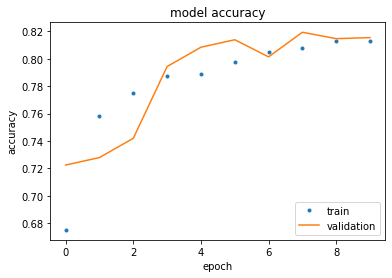

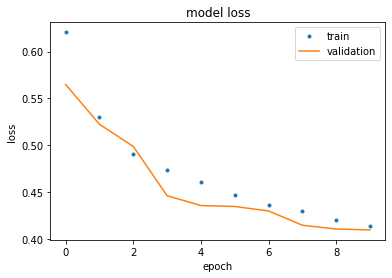

In [12]:
# list all data in history
accuracy = history.history['accuracy']
#summarize history for accuracy
plt.plot(history.history['accuracy'],'.')
plt.plot(history.history['val_accuracy'],'-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'.')
plt.plot(history.history['val_loss'],'-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

849/849 [==============================] - 6s 7ms/step - loss: 0.4505 - accuracy: 0.7982
Test: accuracy = 0.798248  ;  loss = 0.450488 


In [13]:
# Predicting the classes on test set and printing the accuracy
y_pred = model.predict(X_test, verbose=1)

849/849 [==============================] - 3s 3ms/step


In [15]:
Y_PRED = np.where(y_pred > 0.5, 1,0)

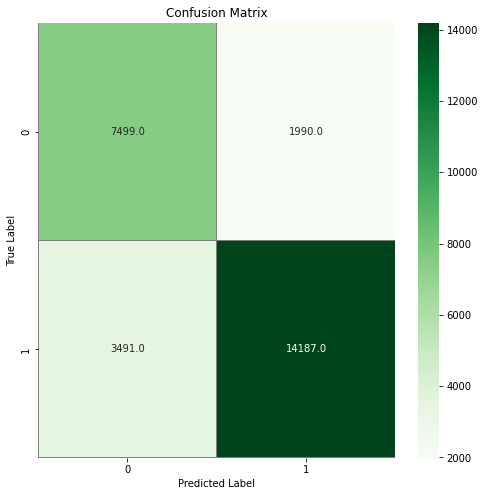

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# # compute the confusion matrix
confusion_mtx = confusion_matrix(Y_test, Y_PRED) 
# # plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### Extract the TP,FP,FN,TN to calculate the Accuracy, Specificity and Sensitivity manually.

In [17]:
TP = confusion_mtx[0][0]
FP = confusion_mtx[0][1]
FN = confusion_mtx[1][0]
TN = confusion_mtx[1][1]

In [18]:
total1=sum(sum(confusion_mtx))
Accuracy = (confusion_mtx[0,0]+confusion_mtx[1,1])/total1
Specificity = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[0,1])
Sensitivity = confusion_mtx[1,1]/(confusion_mtx[1,0]+confusion_mtx[1,1])


In [30]:
report = classification_report(Y_test, Y_PRED, target_names=['F','M'])
print(report)

              precision    recall  f1-score   support

           F       0.80      0.80      0.80      9489
           M       0.89      0.90      0.89     17678

    accuracy                           0.86     27167
   macro avg       0.85      0.85      0.85     27167
weighted avg       0.86      0.86      0.86     27167



In [31]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, Y_PRED)
roc_auc = metrics.auc(fpr, tpr)

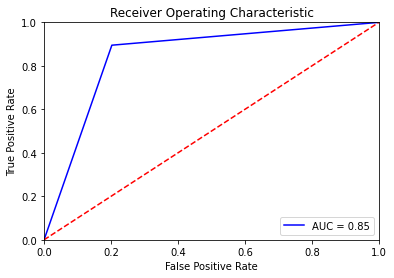

In [32]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# # Save the model to disk.
model.save_weights('model.h5')

# # Load the model from disk later using:
# model.load_weights('model.h5')


# Improved Baseline model

In [23]:
# Fitting the compiling and fitting the sequential model
#.....................................

imp_model = Sequential()

imp_model.add(layers.Input((100, 100, 3))) # Multiple inputs, because of RGB 
imp_model.add(layers.Conv2D(32, (3, 3), activation='relu')) 
                                # 32 nodes gave better performance than 8 and 16 nodes.
                                # Including padding decreased the performance as did data augmentation with ImageDataGenerator.
imp_model.add(layers.MaxPooling2D((2, 2)))

imp_model.add(layers.Dropout(0.3))  # As a huristic Dropout is between 0.2 and 0.5. 
                                # 0.3 gave the best performance, 0.2, 0.4, and 0.5 performend worse.
                                # BatchNormalization performed worse than Dropout
                                
imp_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
                                # 32 nodes gave better performance than 8 and 16 nodes.

imp_model.add(layers.MaxPooling2D((2, 2)))

imp_model.add(layers.Dropout(0.3)) # 0.3 gave the best performance, 0.2, 0.4, and 0.5 performend worse.
 
imp_model.add(layers.Flatten())
imp_model.add(layers.Dense(128, activation='relu')) # 128 nodes gave better performance than 32 and 64 nodes.
                                                # 2 Dense layers performed better than 1, 3 and 4 Dense layers.
imp_model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Normal learning rate x10 because of the Dropouts.
                                                          # Adam optimizer performed better than RMSprop and SGD.
imp_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

history = imp_model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=10, batch_size=160, verbose=1) # Early stopping on val_loss gave 8 epochs. 86% val_acc
                                                                                    # After 10 epochs the model starts overfitting.
                                                                                    # For this reason we choose for 10 epochs. 

Epoch 1/10
70/70 [==============================] - 8s 93ms/step - loss: 0.6987 - accuracy: 0.5962 - val_loss: 0.5689 - val_accuracy: 0.7537
Epoch 2/10
70/70 [==============================] - 6s 82ms/step - loss: 0.5269 - accuracy: 0.7509 - val_loss: 0.4871 - val_accuracy: 0.7772
Epoch 3/10
70/70 [==============================] - 6s 81ms/step - loss: 0.4673 - accuracy: 0.7882 - val_loss: 0.4234 - val_accuracy: 0.8202
Epoch 4/10
70/70 [==============================] - 6s 82ms/step - loss: 0.4159 - accuracy: 0.8151 - val_loss: 0.3935 - val_accuracy: 0.8413
Epoch 5/10
70/70 [==============================] - 6s 84ms/step - loss: 0.3724 - accuracy: 0.8389 - val_loss: 0.3591 - val_accuracy: 0.8514
Epoch 6/10
70/70 [==============================] - 6s 82ms/step - loss: 0.3438 - accuracy: 0.8527 - val_loss: 0.3373 - val_accuracy: 0.8694
Epoch 7/10
70/70 [==============================] - 6s 82ms/step - loss: 0.3205 - accuracy: 0.8629 - val_loss: 0.3176 - val_accuracy: 0.8733
Epoch 8/10
70

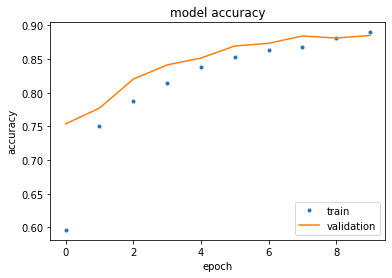

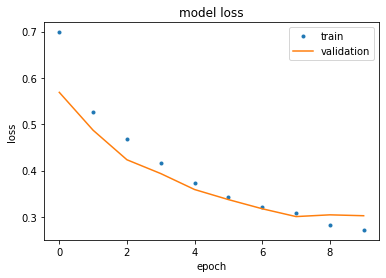

In [24]:
# list all data in history

accuracy = history.history['accuracy']
#summarize history for accuracy
plt.plot(history.history['accuracy'],'.')
plt.plot(history.history['val_accuracy'],'-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'.')
plt.plot(history.history['val_loss'],'-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [33]:
loss, accuracy = imp_model.evaluate(X_test,Y_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

849/849 [==============================] - 7s 9ms/step - loss: 0.3310 - accuracy: 0.8610
Test: accuracy = 0.860971  ;  loss = 0.331033 


In [25]:
# Predicting the classes on test set and printing the accuracy
y_pred = imp_model.predict(X_test, verbose=1)

849/849 [==============================] - 4s 5ms/step


In [26]:
Y_PRED = np.where(y_pred > 0.5, 1,0)

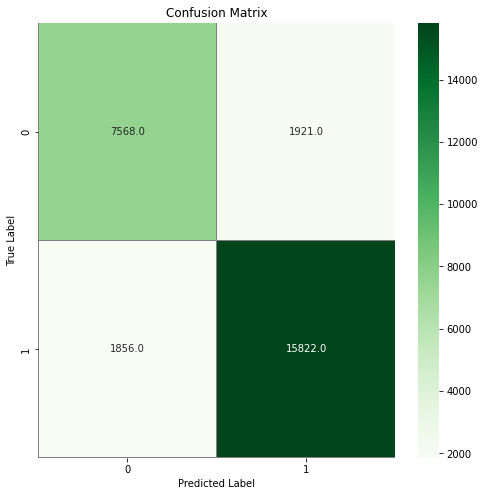

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# # compute the confusion matrix
confusion_mtx = confusion_matrix(Y_test, Y_PRED) 
# # plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### Extract the TP,FP,FN,TN to calculate the Accuracy, Specificity and Sensitivity manually.

In [15]:
TP = confusion_mtx[0][0]
FP = confusion_mtx[0][1]
FN = confusion_mtx[1][0]
TN = confusion_mtx[1][1]

In [16]:
total1=sum(sum(confusion_mtx))
Accuracy = (confusion_mtx[0,0]+confusion_mtx[1,1])/total1
Specificity = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[0,1])
Sensitivity = confusion_mtx[1,1]/(confusion_mtx[1,0]+confusion_mtx[1,1])


In [17]:
report = classification_report(Y_test, Y_PRED, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.82      0.68      0.74      9489
           1       0.84      0.92      0.88     17678

    accuracy                           0.84     27167
   macro avg       0.83      0.80      0.81     27167
weighted avg       0.83      0.84      0.83     27167



In [18]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, Y_PRED)
roc_auc = metrics.auc(fpr, tpr)

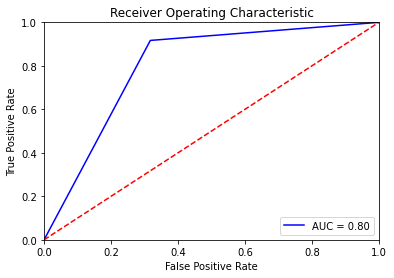

In [19]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:

# # Save the model to disk.
#imp_model.save_weights('imp_model.h5')

# # Load the model from disk later using:
#aug_model.load_weights('/content/gdrive/MyDrive/imp_model.h5')

# Transfer Learning Model Creation

#### Image Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 



In [13]:
train_datagen.fit(X_train)

In [14]:
val_datagen.fit(X_val)

In [15]:
# Generate batches and augment the images
train_generator = train_datagen.flow(X_train,Y_train,shuffle=True,seed=None)
val_generator=val_datagen.flow(X_val,Y_val,shuffle=True,seed=None)

#### Fitting the augmented image on VGG16 model

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
pre_trained_model = VGG16(input_shape=(100,100,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
              metrics=['accuracy'])
vggmodel.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

In [17]:
vgghist=vggmodel.fit(train_generator,epochs=10, validation_data=val_generator,verbose=1)

Epoch 1/10
348/348 [==============================] - 83s 139ms/step - loss: 1.3979 - accuracy: 0.7925 - val_loss: 1.2128 - val_accuracy: 0.8866
Epoch 2/10
348/348 [==============================] - 46s 131ms/step - loss: 1.2768 - accuracy: 0.8533 - val_loss: 1.1944 - val_accuracy: 0.9015
Epoch 3/10
348/348 [==============================] - 45s 130ms/step - loss: 1.2451 - accuracy: 0.8660 - val_loss: 1.1919 - val_accuracy: 0.8968
Epoch 4/10
348/348 [==============================] - 46s 131ms/step - loss: 1.2154 - accuracy: 0.8780 - val_loss: 1.1651 - val_accuracy: 0.9015
Epoch 5/10
348/348 [==============================] - 46s 132ms/step - loss: 1.2058 - accuracy: 0.8823 - val_loss: 1.1347 - val_accuracy: 0.9171
Epoch 6/10
348/348 [==============================] - 45s 130ms/step - loss: 1.1851 - accuracy: 0.8925 - val_loss: 1.1484 - val_accuracy: 0.9132
Epoch 7/10
348/348 [==============================] - 45s 130ms/step - loss: 1.1788 - accuracy: 0.8940 - val_loss: 1.1239 - val_ac

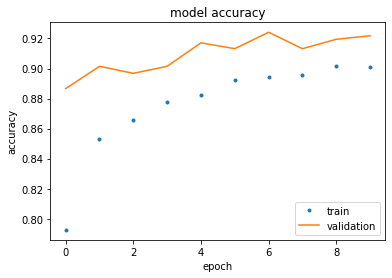

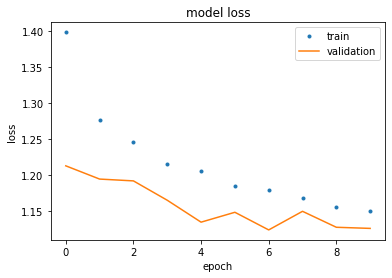

In [18]:
accuracy = vgghist.history['accuracy']
#summarize history for accuracy
plt.plot(vgghist.history['accuracy'],'.')
plt.plot(vgghist.history['val_accuracy'],'-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(vgghist.history['loss'],'.')
plt.plot(vgghist.history['val_loss'],'-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
loss, accuracy = vggmodel.evaluate(X_test,Y_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

849/849 [==============================] - 62s 73ms/step - loss: 1.2280 - accuracy: 0.8671
Test: accuracy = 0.867118  ;  loss = 1.227952 


### Save the model to disk.


In [ ]:
#vggmodel.save_weights('vggmodel.h5')

### Load the model


In [ ]:
# # Load the model from disk later using:
#vggmodel.load_weights('/content/gdrive/MyDrive/vggmodel.h5')

In [19]:
vgg_y_pred =  vggmodel.predict(X_test,verbose=1)

849/849 [==============================] - 56s 66ms/step


In [21]:
vgg_y_p = np.where(vgg_y_pred > 0.5, 1,0)

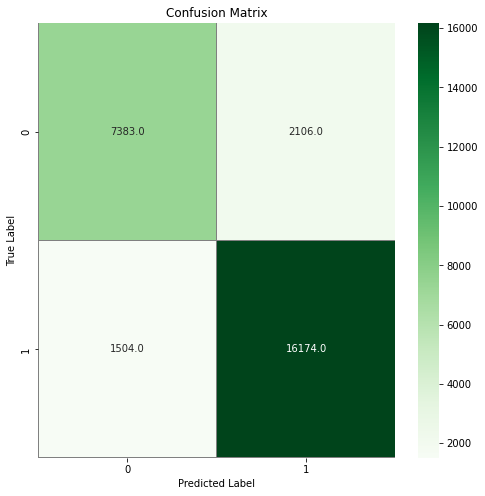

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(Y_test, vgg_y_p) 
# # plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

***The model predicted 16444 males correctly and 7115 Females correctly on the test set. Whereas it predicted 1234 Females as Males and 2374 Males as Female.***

#### Extract the TP,FP,FN,TN to calculate the Accuracy, Specificity and Sensitivity manually.

In [23]:
TP = confusion_mtx[0][0]
FP = confusion_mtx[0][1]
FN = confusion_mtx[1][0]
TN = confusion_mtx[1][1]

In [25]:
total1=sum(sum(confusion_mtx))
Accuracy = (TP+TN)/total1
Specificity = TP/(TP+FP)
Sensitivity = TN/(FN+TN)


# Generate classification report contatining F-1 score, recall and precision.

In [26]:
report = classification_report(Y_test, vgg_y_p, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      9489
           1       0.88      0.91      0.90     17678

    accuracy                           0.87     27167
   macro avg       0.86      0.85      0.85     27167
weighted avg       0.87      0.87      0.87     27167



In [27]:
import sklearn.metrics as metrics
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, vgg_y_p)
roc_auc = metrics.auc(fpr, tpr)

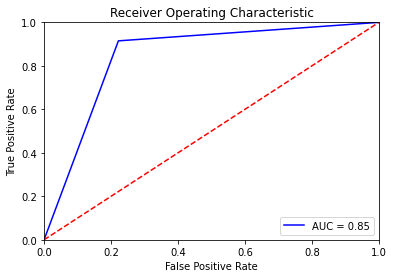

In [28]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()